Author: Ben Holcombe
Credit: This code was adapted from notebooks orignally developed for the Ill Winds Project by Lauren Biermann, School of Biological & Marine Sciences, University of Plymouth.

In [1]:
pip install pymannkendall

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
# Plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as dates
from matplotlib.dates import DateFormatter
# Statistics
import pymannkendall as mk
import numpy as np
import pandas as pd
# NetCDF
import netCDF4 as nc
import os
from scipy.stats import linregress
# Import and ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
MYPATH = os.path.join("/Users","ben","Documents","Dissertation")
input_root = os.path.join(MYPATH)
input_path = "Notebooks"
file_name_chl = 'extracted_chlor_a.nc'

In [4]:
# Accessing the data
in_file = 'extracted_chlor_a.nc'
nc_data = nc.Dataset(in_file)
#nc_data

In [5]:
print(nc_data.variables.keys())

dict_keys(['chlor_a', 'time', 'lat', 'lon'])


In [6]:
# Extract variables time, lat, lon, chlor_a
time= nc_data.variables['time']
lat = np.array(nc_data.variables['lat'] )
lon = np.array(nc_data.variables['lon'] )
adg = np.array(nc_data.variables['chlor_a'])
print(adg.shape)

(294, 125, 292)


In [7]:
# Get your dates into a user-friendly format: dtime is your new date variable
caldr = time.getncattr('calendar')
units = time.getncattr('units')
dtime = nc.num2date(time[:], units, calendar = caldr, only_use_cftime_datetimes = False)

In [8]:
adg_s = []
timesteps = adg.shape[0]
for x in range(timesteps):
    adg_s.append(np.nanmean(adg[x,:]))

In [9]:
# Create DataFrame
df_s = pd.DataFrame({'Date': dtime, 'Chlorophyll': adg_s})
print(df_s.head())  # Display first few rows

        Date  Chlorophyll
0 2000-01-01     0.174978
1 2000-02-01     0.197036
2 2000-03-01     0.163181
3 2000-04-01     0.153744
4 2000-05-01     0.156727


In [10]:
# Make date format more friendly to use
df_s['Date'] = pd.to_datetime(df_s['Date'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')
df_s.head(4)

,Date,Chlorophyll
0,2000-01-01,0.174978
1,2000-02-01,0.197036
2,2000-03-01,0.163181
3,2000-04-01,0.153744


In [11]:
# Using pandas.Series.dt.year() & pandas.Series.dt.month() method
df_s['Year'] = df_s['Date'].dt.year 
df_s['Month']= df_s['Date'].dt.month 
#print("Get month and year from datetime column:\n", df_sm)

In [12]:
# Make df with data from 2000-01-01 to 2024-01-01
df_s = df_s[(df_s['Year'] >= 2000) & (df_s['Year'] <= 2024)]
df_s.head(3)

,Date,Chlorophyll,Year,Month
0,2000-01-01,0.174978,2000,1
1,2000-02-01,0.197036,2000,2
2,2000-03-01,0.163181,2000,3


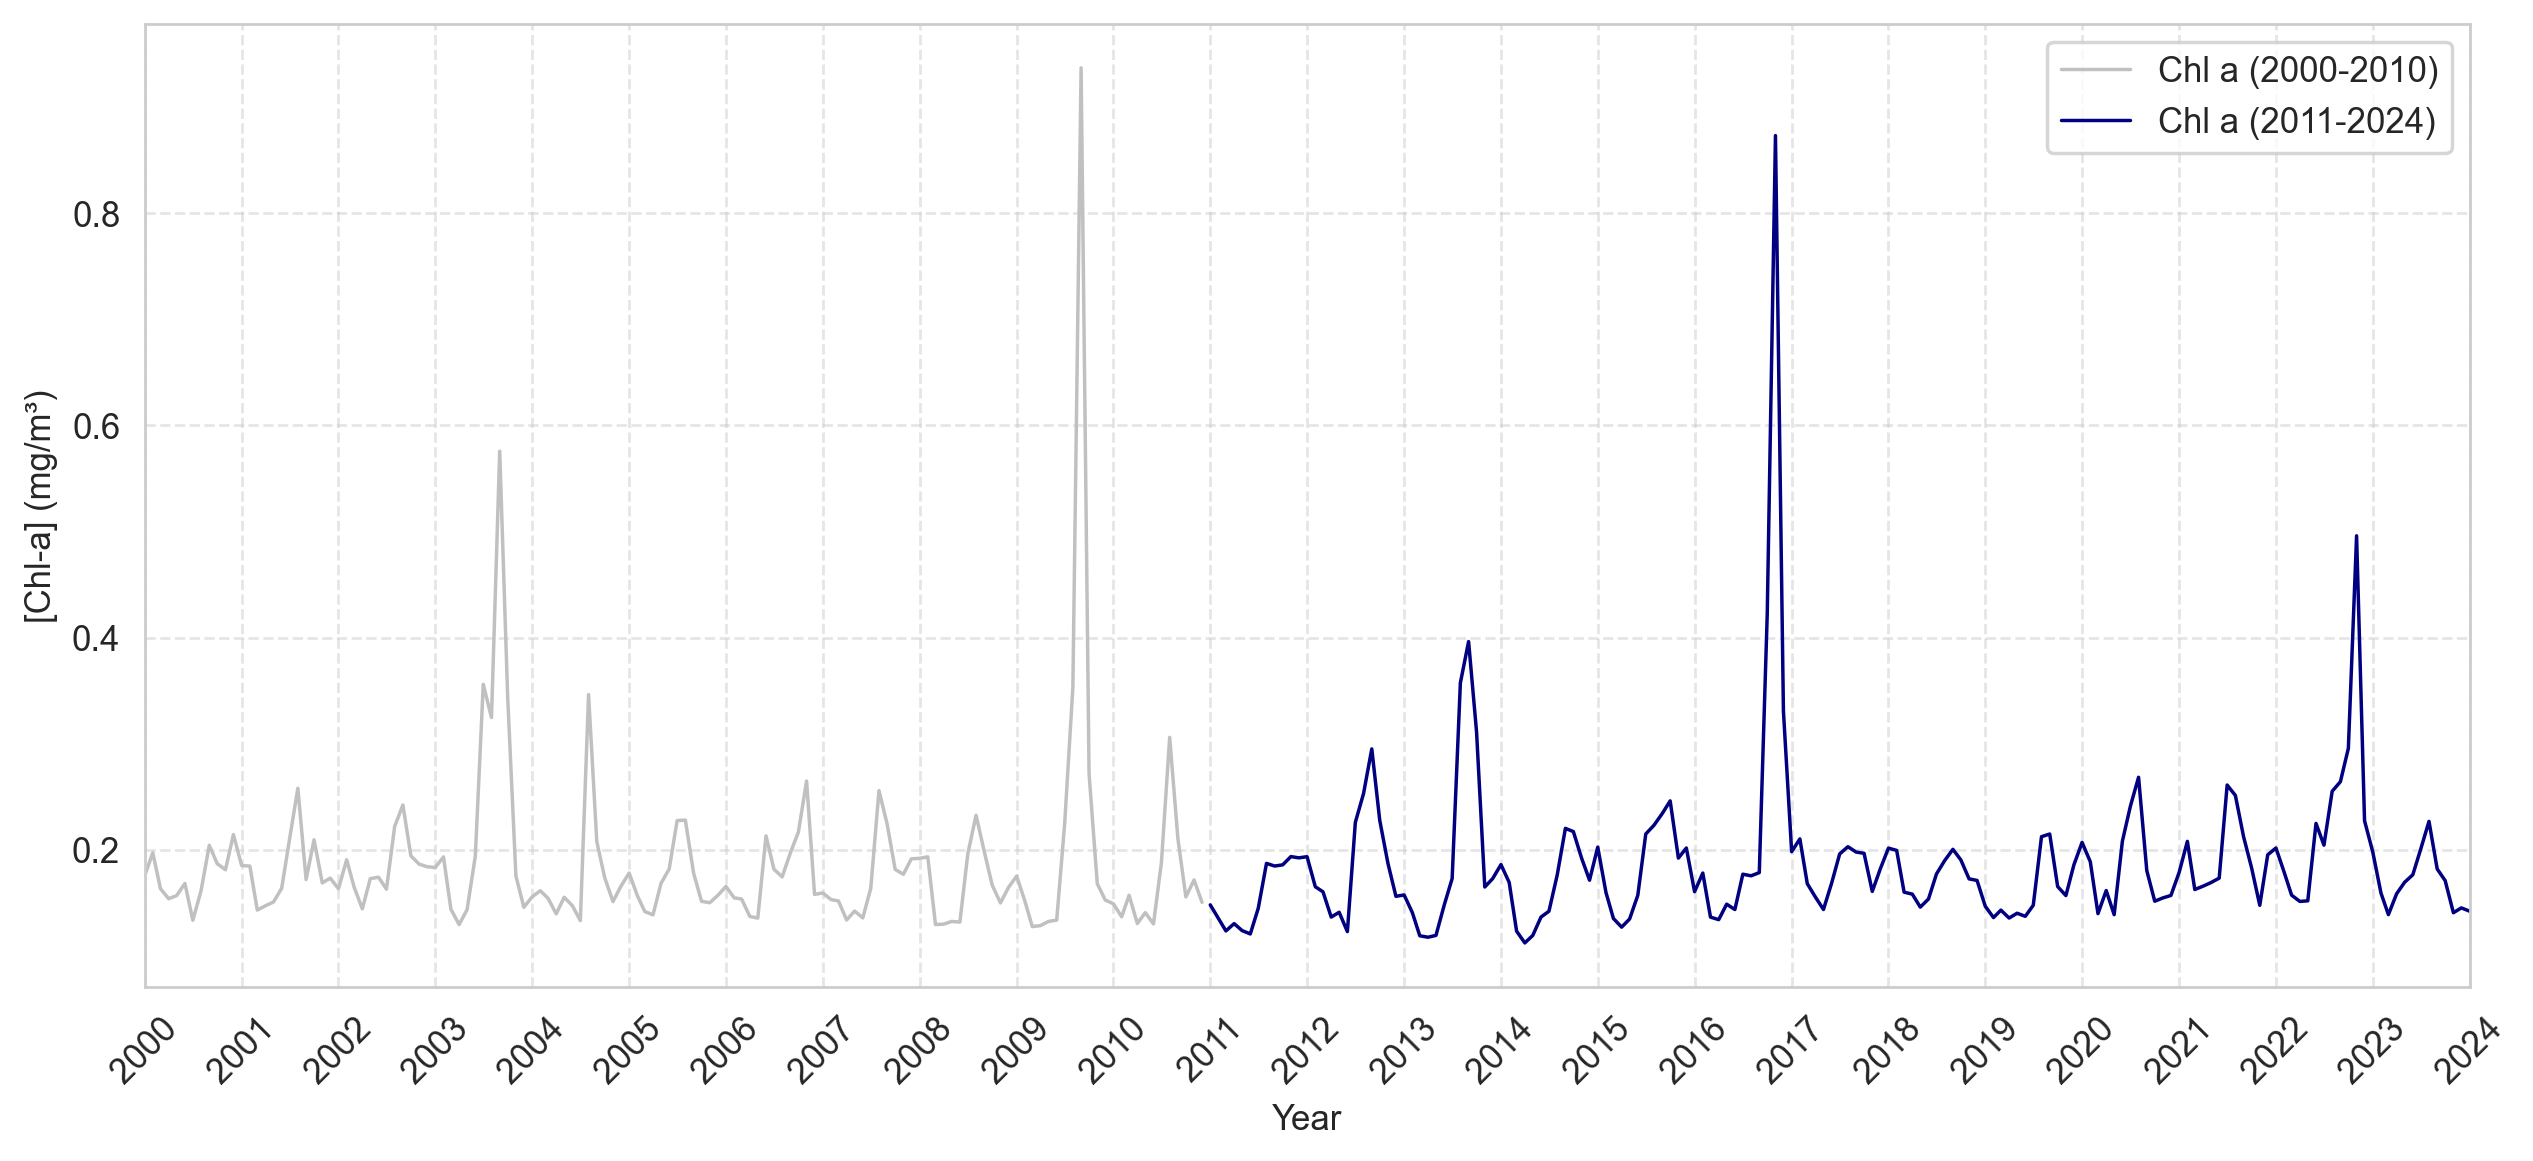

In [23]:
# Ensure 'Time' is in datetime format
df_s['Time'] = pd.to_datetime(df_s['Date'])

# Filter data for the two periods
mask_2000_2010_Mean = (df_s.Time >= '2000-01-01') & (df_s.Time < '2011-01-01')
mask_2011_2024_Mean = (df_s.Time >= '2011-01-01') & (df_s.Time <= '2024-01-01')

df_2000_2010_m = df_s[mask_2000_2010_Mean]
df_2011_2024_m = df_s[mask_2011_2024_Mean]

# Create figure and axis
fig2, ax = plt.subplots(figsize=(12, 5), dpi=250)

# Set x-axis limits (clip to 2000-2024)
ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2024-01-01'))

# Set yearly ticks for x-axis
ax.xaxis.set_major_locator(dates.YearLocator(1))  # Every year
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))  # Format as Year
plt.setp(ax.get_xticklabels(), rotation=45)  # Rotate labels for better visibility

# Plot chlorophyll time series for both periods
plt.plot(df_2000_2010_m.Time, df_2000_2010_m.Chlorophyll, linewidth=1.0, c='silver', linestyle='-', label="Chl a (2000-2010)")
plt.plot(df_2011_2024_m.Time, df_2011_2024_m.Chlorophyll, linewidth=1.0, c='navy', linestyle='-', label="Chl a (2011-2024)")

# Add labels and legend
plt.xlabel('Year')
plt.ylabel('[Chl-a] (mg/m³)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)  # Optional: Add grid lines
plt.show()

fig2.savefig('TimeSeriesMonthly', bbox_inches='tight')

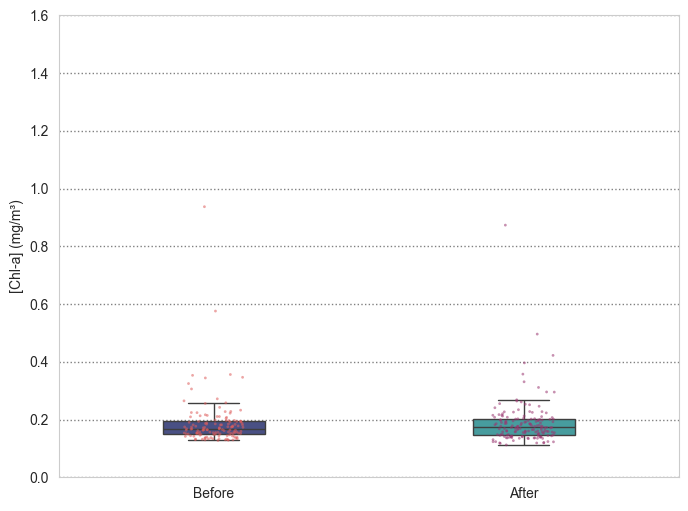

In [27]:
# Boxplot with Seaborn
import seaborn as sns
box1 = pd.DataFrame({'Before':df_2000_2010_m.Chlorophyll, 'After':df_2011_2024_m.Chlorophyll})
sns.set_style('whitegrid')
# Create a figure with two subplots (1 row, 2 columns)
fig3, (ax1) = plt.subplots(1, 1, figsize=(8, 6))  # Adjust figsize as needed
sns.boxplot(data=box1, width=.33, palette="mako",flierprops=dict(marker=''),ax=ax1)
sns.stripplot(data=box1, palette="flare", s=2, jitter=True, alpha=0.55,ax=ax1)
# Limits, Gridlines, Title
ax1.set_ylim([0, 1.6])  # Set y-limits for 'Chl'
ax1.set_ylabel('[Chl-a] (mg/m³)', fontsize=10)
ax1.grid(True, linestyle=':', linewidth=1, color='gray', axis='y')

fig3.savefig('BoxplotMonthly', bbox_inches='tight')

In [15]:
# Data Prep for Linear regression:
x_date = df_s['Time']              # Your actual dates
x_num1 = dates.date2num(x_date)  # Convert dates to numerical format
CHL = df_s["Chlorophyll"]                  # Your CHL data


# Perform linear regression
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(x_num1, CHL)

# Calculate the trendlines
trend_CHL = slope1 * x_num1 + intercept1

In [16]:
# Split the data into two sets: before 2011 and from 2011 onwards
df_Be = pd.DataFrame({'Time':df_2000_2010_m.Time, 'Chlorophyll':df_2000_2010_m.Chlorophyll})
df_Af = pd.DataFrame({'Time':df_2011_2024_m.Time, 'Chlorophyll':df_2011_2024_m.Chlorophyll})

In [17]:
# Significant CHL?
trend3 = mk.original_test(df_Be['Chlorophyll'])
trend4 = mk.original_test(df_Af['Chlorophyll'])
print("Trend before:",trend3[0], ", p-value =", ("%.3f" % trend3[2]))
print("Trend after:", trend4[0], ", p-value =", ("%.3f" % trend4[2]))

Trend before: no trend , p-value = 0.098
Trend after: increasing , p-value = 0.021
